# Heatwave Prediction using XGBoost and LSTM

This notebook demonstrates how to build machine learning models using XGBoost (a tree-based method) and an LSTM (a deep learning sequential model) to predict heatwave events based on weather parameters. The dataset includes date/time information, temperature/humidity, wind/evaporation, and rainfall/pressure data.

A heatwave event is defined here (for demonstration) as when the dew point temperature (DPT) exceeds **28°C**. Adjust the threshold as needed.

The notebook contains the following sections:

1. Data Loading and Overview
2. Data Preprocessing & Feature Engineering
3. Building & Evaluating the XGBoost Model
4. Building & Evaluating the LSTM Model
5. Saving the Trained Models as Pickle Files
6. Instructions for Integrating with a Flask Backend REST API


### 🔧 Install Required Python Packages

Run the following cell to ensure all the necessary libraries are installed. You may skip it if the libraries are already available in your environment.


In [ ]:
# Install required packages (run only once if not already installed)
!pip install pandas numpy matplotlib scikit-learn xgboost tensorflow

In [4]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sklearn libraries for splitting data and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# XGBoost
import xgboost as xgb

# TensorFlow / Keras for LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# For saving models
import pickle

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


## 1. Data Loading and Overview

Load the dataset. Here, we assume the CSV file (`santacruz_cleaned_merged.csv`) is in the same directory. Review a few rows to understand the structure.

In [1]:
# Upload the dataset manually in Google Colab
from google.colab import files
uploaded = files.upload()

# Load the dataset
import pandas as pd
df = pd.read_csv('santacruz_colaba_merged_cleaned.csv')  # Make sure the uploaded filename matches

# Display the first few rows
print(df.head())

# Display dataset info
print(df.info())


Saving santacruz_colaba_merged_cleaned.csv to santacruz_colaba_merged_cleaned.csv
   INDEX  YEAR  MN  HR  DT     SLP    MSLP   DBT   WBT   DPT  ...    h    c  \
0  43057  2010   1  12   1  1011.0  1012.2  23.2  20.4  18.8  ...  7.0  4.0   
1  43057  2010   1  12   2  1011.7  1012.9  24.6  22.2  21.0  ...  9.0  4.0   
2  43057  2010   1  12   4  1013.4  1014.6  23.4  20.0  18.0  ...  9.0  4.0   
3  43057  2010   1  12   5  1011.5  1012.7  21.0  20.6  20.4  ...  9.0  4.0   
4  43057  2010   1  12   6  1010.5  1011.7  22.4  21.4  20.9  ...  9.0  4.0   

     a    Ht   RF  EVP   DW    P    H    WAT  
0  0.0  99.0  0.0  5.0  0.0  7.0  0.0  210.0  
1  0.0  99.0  0.0  8.0  0.0  7.0  0.0  226.0  
2  0.0  99.0  0.0  6.0  0.0  7.0  0.0  218.0  
3  0.0  99.0  0.0  6.0  0.0  7.0  0.0  204.0  
4  0.0  99.0  0.0  8.0  0.0  7.0  0.0  210.0  

[5 rows x 36 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211567 entries, 0 to 211566
Data columns (total 36 columns):
 #   Column  Non-Null Count

<ipython-input-1-e8ebde839f9f>:7: DtypeWarning: Columns (17,19,21,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('santacruz_colaba_merged_cleaned.csv')  # Make sure the uploaded filename matches


## 2. Data Preprocessing & Feature Engineering

In this cell we perform some basic preprocessing steps:

- **Date/Time Parsing:** Create a proper datetime column from the available date components if needed.
- **Target Definition:** Define a new target column `heatwave` based on whether `DPT` exceeds a threshold (here 28°C). Adjust the threshold based on the domain understanding.
- **Handling Missing Values:** (For a real project, you should handle or impute missing values appropriately.)
- **Feature Selection:** We use available features such as `DT`, `MN`, `HR`, `DPT`, `RH`, `FFF`, `AW`, `DD`, `EVP`, `RF`, `SLP`, and `MSLP`.


In [2]:
# Create a datetime column if needed (handling invalid dates)
if 'DATE' not in df.columns:
    df['DATE'] = pd.to_datetime(
        df['MN'].astype(str) + '/' + df['DT'].astype(str) + '/2023',
        format='%m/%d/%Y',
        errors='coerce'  # convert invalid dates to NaT
    )

# Drop rows where date conversion failed
df = df.dropna(subset=['DATE'])

# Define heatwave event: for demonstration, we set heatwave=1 if DPT > 28 else 0
heatwave_threshold = 28
df['heatwave'] = (df['DPT'] > heatwave_threshold).astype(int)

# Select features (adjust list as needed)
features = ['DT', 'MN', 'HR', 'DPT', 'RH', 'FFF', 'AW', 'DD', 'EVP', 'RF', 'SLP', 'MSLP']
target = 'heatwave'

# Drop rows with any missing values in features or target
df = df.dropna(subset=features + [target])

# Display distribution of target
print(df[target].value_counts())


heatwave
0    211052
1       367
Name: count, dtype: int64


<ipython-input-2-c8b6609acdcd>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['heatwave'] = (df['DPT'] > heatwave_threshold).astype(int)


## 3. Building & Evaluating the XGBoost Model

We first split the data into training and testing sets. Then we train an XGBoost classifier, evaluate it with a confusion matrix, and visualize the results.

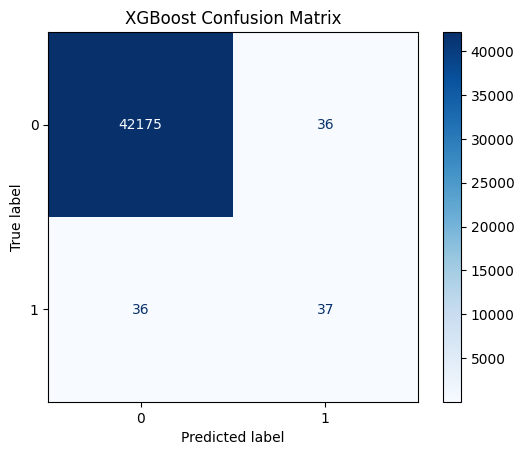

XGBoost Confusion Matrix:
[[42175    36]
 [   36    37]]


In [5]:
# Split the data (80-20 split)
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)

# Compute confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title('XGBoost Confusion Matrix')
plt.show()

# For reference, print confusion matrix numbers
print('XGBoost Confusion Matrix:')
print(cm_xgb)

## 4. Building & Evaluating the LSTM Model

For the LSTM model, we must transform our data into a time‐series format. Here, we create sliding windows from the dataset in order to predict a heatwave event. In this example, we assume hourly data and use a sliding window (e.g., 24 hours of past data) to predict the next hour’s heatwave occurrence. For forecasting the next 7 days (168 hours), you can iterate your predictions.

Below we:

- Create sequences from the dataset
- Split into training and test sequences
- Build a simple LSTM model using Keras
- Evaluate using a confusion matrix (comparing predicted binary labels after thresholding on the output probability)


Epoch 1/50
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 64s 14ms/step - accuracy: 0.9900 - loss: 0.0708 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 2/50
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 59s 14ms/step - accuracy: 0.9973 - loss: 0.0192 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 3/50
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 87s 15ms/step - accuracy: 0.9973 - loss: 0.0191 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 4/50
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 77s 14ms/step - accuracy: 0.9974 - loss: 0.0187 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 5/50
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 82s 14ms/step - accuracy: 0.9972 - loss: 0.0200 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 6/50
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 59s 14ms/step - accuracy: 0.9970 - loss: 0.0209 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 7/50
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 59s 14ms/step - accuracy: 0.9974 - loss: 0.0182 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 8/50
4228/4228 ━━━━━━━━━━━━━━━━━━━━ 62s 15ms/step - accuracy: 0.9972 -

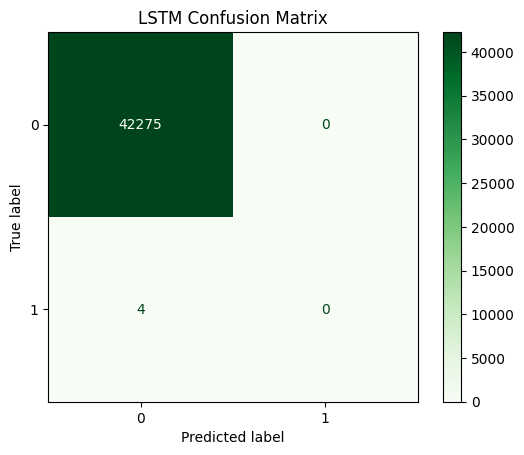

LSTM Confusion Matrix:
[[42275     0]
 [    4     0]]


In [6]:
def create_sequences(data, seq_length=24):
    X_seq = []
    y_seq = []
    for i in range(len(data) - seq_length):
        X_seq.append(data.iloc[i:i+seq_length][features].values)
        # target: predict heatwave event at the next time-step
        y_seq.append(data.iloc[i+seq_length][target])
    return np.array(X_seq), np.array(y_seq)

# Create sequences
sequence_length = 24  # using past 24 hours
X_seq, y_seq = create_sequences(df, seq_length=sequence_length)

# Split sequence data (80-20 split)
split_index = int(0.8 * len(X_seq))
X_seq_train, X_seq_test = X_seq[:split_index], X_seq[split_index:]
y_seq_train, y_seq_test = y_seq[:split_index], y_seq[split_index:]

# Build LSTM Model
timesteps = X_seq_train.shape[1]
n_features = X_seq_train.shape[2]

lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(timesteps, n_features), return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = lstm_model.fit(X_seq_train, y_seq_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop])

# Predict on test sequences
y_pred_lstm_prob = lstm_model.predict(X_seq_test)
y_pred_lstm = (y_pred_lstm_prob > 0.5).astype(int).ravel()

# Compute confusion matrix
cm_lstm = confusion_matrix(y_seq_test, y_pred_lstm)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_lstm, display_labels=[0,1])
disp2.plot(cmap=plt.cm.Greens)
plt.title('LSTM Confusion Matrix')
plt.show()

print('LSTM Confusion Matrix:')
print(cm_lstm)

## 5. Predicting the Next 7 Days (Hourly) and Printing Predictions

We now simulate predictions for the next 7 days (i.e., 168 hours). In a real scenario, you would use your trained models along with forecasted features. Here we use the last available sliding window from the dataset to iteratively predict the next hour, append it to the window (shifting the window), and repeat for 168 steps.

We demonstrate this for the XGBoost model. A similar approach can be applied for LSTM if desired.

In [7]:
# Prepare for iterative prediction over 168 hours using the last available record as the seed

def iterative_prediction(model, seed_df, steps=168):
    preds = []
    current_window = seed_df.copy()
    for i in range(steps):
        # Predict based on current window (take the last row of features)
        features_last = current_window[features].iloc[-1].values.reshape(1, -1)
        pred = model.predict(features_last)[0]
        preds.append(pred)

        # Simulate the passage of one hour
        new_row = current_window.iloc[-1].copy()
        new_row['HR'] = (new_row['HR'] + 1) % 24

        # Append the new_row and keep window size fixed
        current_window = pd.concat([current_window, pd.DataFrame([new_row])], ignore_index=True)
        current_window = current_window.iloc[1:]
    return preds


# Use the last 24 hours from the dataset as seed
seed_window = df.tail(24)
predicted_heatwaves = iterative_prediction(xgb_model, seed_window, steps=168)

# Create a DataFrame of predictions with hourly labels
future_hours = pd.date_range(start=seed_window['DATE'].iloc[-1] + pd.Timedelta(hours=1), periods=168, freq='H')
pred_df = pd.DataFrame({'Timestamp': future_hours, 'Predicted_Heatwave': predicted_heatwaves})

# Print the prediction DataFrame
print(pred_df.head(20))  # print first 20 predictions for brevity

# Optionally, save the predictions to a CSV
pred_df.to_csv('next_7days_heatwave_predictions.csv', index=False)

             Timestamp  Predicted_Heatwave
0  2023-12-30 01:00:00                   0
1  2023-12-30 02:00:00                   0
2  2023-12-30 03:00:00                   0
3  2023-12-30 04:00:00                   0
4  2023-12-30 05:00:00                   0
5  2023-12-30 06:00:00                   0
6  2023-12-30 07:00:00                   0
7  2023-12-30 08:00:00                   0
8  2023-12-30 09:00:00                   0
9  2023-12-30 10:00:00                   0
10 2023-12-30 11:00:00                   0
11 2023-12-30 12:00:00                   0
12 2023-12-30 13:00:00                   0
13 2023-12-30 14:00:00                   0
14 2023-12-30 15:00:00                   0
15 2023-12-30 16:00:00                   0
16 2023-12-30 17:00:00                   0
17 2023-12-30 18:00:00                   0
18 2023-12-30 19:00:00                   0
19 2023-12-30 20:00:00                   0


## 6. Saving the Trained Models as Pickle Files

We now save the XGBoost model and the LSTM model as pickle files. (Note: For the Keras LSTM, you might also consider using the built-in model saving methods such as `model.save()`, but here we show pickle for consistency.)

In [8]:
# Save XGBoost model
with open('xgb_heatwave_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

# Save LSTM model using Keras built-in method (recommended)
lstm_model.save('lstm_heatwave_model.h5')

# Alternatively, to use pickle with Keras, you can use joblib or similar, but the .h5 format is preferred.

## 7. Integrating the Model with a Flask REST API

Below is a sample Flask application code snippet that shows how to load the saved models and create REST API endpoints for making predictions. You can save the following code as, for example, `app.py` and run it using Flask.

```python
from flask import Flask, request, jsonify
import pandas as pd
import numpy as np
import pickle
from tensorflow.keras.models import load_model

app = Flask(__name__)

# Load the saved models
with open('xgb_heatwave_model.pkl', 'rb') as f:
    xgb_model = pickle.load(f)

lstm_model = load_model('lstm_heatwave_model.h5')

# Define an endpoint for XGBoost prediction
@app.route('/predict/xgb', methods=['POST'])
def predict_xgb():
    data = request.get_json(force=True)
    # Assume data is sent as a dictionary with required features
    df_input = pd.DataFrame([data])
    prediction = int(xgb_model.predict(df_input)[0])
    return jsonify({'prediction': prediction})

# Define an endpoint for LSTM prediction (for single time-step prediction)
@app.route('/predict/lstm', methods=['POST'])
def predict_lstm():
    data = request.get_json(force=True)
    # Assume data is sent as a list of hourly records (24 hours) for features
    # data should be a list of dictionaries
    df_input = pd.DataFrame(data)
    sequence = df_input[ [ 'DT', 'MN', 'HR', 'DPT', 'RH', 'FFF', 'AW', 'DD', 'EVP', 'RF', 'SLP', 'MSLP' ]].values
    sequence = np.expand_dims(sequence, axis=0)  # shape: (1, timesteps, features)
    pred_prob = lstm_model.predict(sequence)[0][0]
    prediction = int(pred_prob > 0.5)
    return jsonify({'prediction': prediction, 'probability': float(pred_prob)})

if __name__ == '__main__':
    app.run(debug=True)
```

### How to Use

1. Save the above Flask app code to a file (e.g., `app.py`).
2. Run the application with `python app.py`.
3. Use any REST API client (like Postman or curl) to send POST requests to `/predict/xgb` or `/predict/lstm` with JSON payloads of the required features.
